# The Data
All data were downloaded on January 27, 2021 from the EPA's [air quality system](https://aqs.epa.gov/aqsweb/airdata/download_files.html) pregenerated files. A description of the data format can be found [here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_daily_summary_files).

I downloaded pre-generated csv files for wind, air pressure, relative humdity and dew point, and temperature. Each of the csv files contains daily summaries for one year of data. For example, daily average PM2.5 concentrations for 2010 are all contained in one file

This notebook's purpose is to create CSV files of each feature for each station. The goal is to create a csv file where the row correspondes to one date and each column represents the reading for a particular feature (e.g., wind). There is no pre-processing of the data to remove NaNs or estimate missing values. The goal is merely to create a csv file which contains formatted data so that the actual analysis can be done cleanly and without worrying about formatting the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import itertools

In [2]:
# A ISO format DateTime generator
# https://stackoverflow.com/a/993369/5217293
def date_generator(start = datetime.datetime.now(), end = None, as_string = False, format = '%Y-%m-%d'):
    date = start
    if end is None:
        # end the generator one day after the start
        end = start + datetime.timedelta(days=1)
    while date < end:
        if as_string:
            yield date.strftime(format)
        else:
            yield date
        date = date + datetime.timedelta(days=1)

Each data file has readings for every station. Below, a single dataframe will be created for each station. Each type of file (wind, PM2.5, etc.) has a different format. The functions below will help to create the final dataframe.

In [23]:
def empty_dataframe(start = '2010-01-01', end = '2020-12-31'):
    """ Create an empty dataframe.
    
    The index of the dataframe is an ISO formatted date (e.g., 2010-01-01). The columns are all of the features
    that are needed (e.g., AQI, Pressure, etc.).
    """
    data_start = datetime.date.fromisoformat(start)
    data_end = datetime.date.fromisoformat(end)
    dates = list(date_generator(start = data_start, end=data_end))

    zeros = np.zeros(len(dates))

    df = pd.DataFrame.from_dict({
        'PM2.5': zeros,
        'AQI': zeros,
        'Temperature': zeros,
        'Wind Speed - Resultant': zeros,
        'Wind Direction - Resultant': zeros,
        'Relative Humidity': zeros,
        'Dew Point': zeros,
        'Pressure': zeros,
        'Date': dates
    })
    df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
    return df.set_index('Date')

def read_file(filename):
    """ Read a zip file of data into a formatted dataframe.
    
    Each type of file has some processing that should be done on all files. In particular this file
    will create a date column from the date field and set that as the index. This function will also
    filter out all data not in Harris county. Columns that are not used by any function are dropped here.
    """
    df = pd.read_csv(filename)
    df = df[df['County Name'] == 'Harris']
    df = df.rename(columns={'Date Local': 'Date'})
    df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
    df = df.set_index('Date')
    df = df.drop(
            [
            'State Code',
            'County Code',
            'Site Num',
            'Parameter Code',
            'POC',
            'Datum',
            'Sample Duration',
            'Pollutant Standard',
            'Event Type',
            'Observation Count',
            'Observation Percent',
            '1st Max Value',
            '1st Max Hour',
            'Method Code',
            'Method Name',
            'State Name',
            'County Name',
            'City Name',
            'CBSA Name',
            'Date of Last Change',
            ], 
            axis = 1
        )
    return df
    

def extract_pm25(df):
    """ Split the dataframe by site and extract the AQI and arithmetic mean.
    
    In this dataset, the AQI is the aggregated index of all particulates and pollutants.
    Artihmetic mean is the mean of PM2.5.
    """
    dfs = {}
    for site, _df in df.groupby('Local Site Name'):
        _df = _df.sort_index()
        _df = _df[['AQI', 'Arithmetic Mean']]
        _df = _df.rename(columns=
            {
            'Arithmetic Mean' : 'PM2.5',
            }
        )
        # if a site has multiple monitors, there could be multiple readings
        # those would appear as readings on the same date
        # groupby the date and then average the values
        dfs[site] = _df.groupby(['Date']).mean()

    return dfs

def extract_pressure(df):
    """ Split the dataframe by site and extract the pressure measurements.
    """
    dfs = {}
    for site, _df in df.groupby('Local Site Name'):
        _df = _df.sort_index()
        _df = _df[['Arithmetic Mean']]
        _df = _df.rename(columns=
            {
            'Arithmetic Mean' : 'Pressure',
            }
        )
        dfs[site] = _df.groupby(['Date']).mean()
    return dfs

def extract_wind(df):
    """ Split the dataframe by site and extract the wind measurements.
    
    This date set has two measured components: Wind Speed - Resultant, Wind Direction - Resultant.
    These will be extracted into their own columns
    """
    dfs = {}
    for site, _df in df.groupby('Local Site Name'):
        _df = _df.sort_index()
        site_parameter_dfs = []
        for parameter, parameter_df in _df.groupby('Parameter Name'):
            parameter_df = parameter_df[['Arithmetic Mean']]
            parameter_df = parameter_df.rename(columns=
                {
                'Arithmetic Mean' : parameter,
                }
            )
            site_parameter_dfs.append(parameter_df)
        concat = pd.concat(site_parameter_dfs, axis=1)
        dfs[site] = concat.groupby('Date').mean()
            
    return dfs

def extract_rh_dp(df):
    """ Split the dataframe by site and extract the relative humidity and dew point.
    
    This date set has two measured components: Dew Point, Relative Humidity.
    These will be extracted into their own columns
    """
    dfs = {}
    for site, _df in df.groupby('Local Site Name'):
        _df = _df.sort_index()
        site_parameter_dfs = []
        for parameter, parameter_df in _df.groupby('Parameter Name'):
            parameter_df = parameter_df[['Arithmetic Mean']]
            parameter_df = parameter_df.rename(columns=
                {
                'Arithmetic Mean' : parameter,
                }
            )
            site_parameter_dfs.append(parameter_df)
        concat = pd.concat(site_parameter_dfs, axis=1)
        dfs[site] = concat.groupby('Date').mean()
            
    return dfs

def extract_temp(df):
    """ Split the dataframe by site and extract the temperature measurements.
    """
    dfs = {}
    for site, _df in df.groupby('Local Site Name'):
        _df = _df.sort_index()
        _df = _df[['Arithmetic Mean']]
        _df = _df.rename(columns=
            {
            'Arithmetic Mean' : 'Temperature',
            }
        )
        dfs[site] = _df.groupby(['Date']).mean()
    return dfs

def collect_locations(locations, df):
    """ Combine location data for all sites into a dataframe
    """
    # take away the index on the date
    _df = df.reset_index()
    # drop non-location columns
    _df = _df.drop(
        [
            'Date',
            'AQI',
            'Parameter Name',
            'Units of Measure',
            'Arithmetic Mean',
        ],
        axis=1
    )
    # drop the duplicates so that there is one entry per location
    if locations is None:
        locations = _df
    else:
        locations = locations.append(_df)
    return locations

Now, all of the data are in their own file for each year. Loop through each year and feature. Extract the data by locaiton and combine all of the features into one data frame.

In [24]:
# the data ranged from 2010-2020
years = range(2010, 2021)
# these are the identifiers for each of the features used in the filenames
features = ['88101', 'PRESS', 'WIND', 'RH_DP', 'TEMP']
# this will collect the units for reference later on
units = {}
# this will collect the locations of the sites
locations = None

# dictionary mapping site name to the final dataframe
all_dfs = {}

for feature in features:
    for year in years:
        filename = f'daily_{feature}_{year}.zip'
        df = read_file(filename)
        
        # extract the units and locations
        units[feature] = df['Units of Measure'].iloc[0]
        locations = collect_locations(locations, df)
        
        # now, get a dataframe index by the date and containing columns only for the feature
        if feature == '88101':
            dfs = extract_pm25(df)
            
        elif feature == 'PRESS':
            dfs = extract_pressure(df)

        elif feature == 'WIND':
            dfs = extract_wind(df)
            
        elif feature == 'RH_DP':
            dfs = extract_rh_dp(df)
            
        elif feature == 'TEMP':
            dfs = extract_temp(df)
            
        else:
            raise f"Invalid feature type: {feature}"

        for site, _df in dfs.items():
            if site not in all_dfs:
                all_dfs[site] = empty_dataframe()
            all_dfs[site].update(_df)

Plot all of the data

In [25]:
for site, _ in all_dfs.items():
    print(site)

Baytown
Clinton
Houston Aldine
Houston Deer Park #2
Houston North Loop
Houston East
Park Place
Cesar Chavez
Channelview
Galena Park
HOUSTON REGIONAL OFFICE
HOUSTON WHARTON
Houston Bayland Park
Houston Croquet
Houston Kirkpatrick
Houston Westhollow
Jacinto Port
Lamkin Elementary
Lynchburg Ferry
Manchester/Central
Milby Park
Northwest Harris County
Pasadena North
San Jacinto Elementary School - Deer Park Junior High School*
Seabrook Friendship Park
Shore Acres
Young Scholars Academy
Baytown Garth
La Porte Airport C243
Houston Southwest Freeway


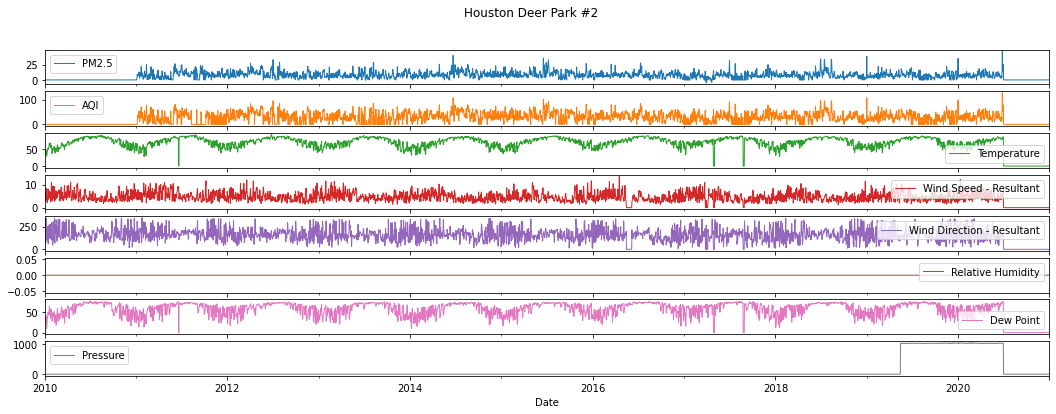

In [26]:
site = 'Houston Deer Park #2'
a_df = all_dfs[site]
fig = a_df.plot(subplots=True, figsize=(18, 6), title=site, lw=1)
plt.gcf().savefig('houston-data.png')

Save the data to its own csv file.

In [ ]:
# turn the units into a dataframe so that we can save the off to a csv file
units_df = pd.DataFrame.from_dict({'Feature': units.keys(), 'Units': units.values()})


for site, df in all_dfs.items():
    df.to_csv(f'{site.replace("/", "-")}.csv')

# lastly, remove any duplicate locations and reset the index
locations = locations.drop_duplicates().reset_index(drop=True)
locations.to_csv(f'locations.csv')